# Data Mining Project - Time Series
**Consider the dataset of time series CityGlobalTemperature2000-2009.csv containing for 100 cities the temperature measurements (mean and standard deviation over a month).**

**The goal of the task is to find groups of similar cities with respect to the temperature trends.**

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import matplotlib
import plotly.express as px
import random

### Utils functions:

In [2]:
def random_colors(n=1):
    colors = []
    for i in range(0,n):
        colors.append((round(random.random(), 3), round(random.random(), 3), round(random.random(), 3)))
    return colors

In [3]:
def set_labels(km):
    i = 0
    for city in cities:
        df.loc[df['City'] == city,'label'] = km.labels_[i]
        i += 1

In [4]:
def plot_time_series():
    fig, axs = plt.subplots(figsize=(17,6))
    colors=['blue', 'purple', 'orange', 'yellow']
    dates = df["time"].unique()
    for city in df["City"].unique().tolist():
        color = int(df[df['City'] == city]['label'].value_counts().index[0])
        plt.plot(dates, df[df['City'] == city]['AverageTemperature'], color=colors[color], figure=fig)
    axs.set_xticks(axs.get_xticks()[::12])

### Loading the Dataset

In [5]:
pd.options.display.max_columns = None
df = pd.read_csv('CityGlobalTemperature2000-2009.csv', sep=',', index_col=0)

In [6]:
df.head()

AverageTemperature  AverageTemperatureUncertainty     City  \
1813              27.685                          0.267  Abidjan   
1814              29.061                          0.224  Abidjan   
1815              28.162                          0.478  Abidjan   
1816              27.547                          0.509  Abidjan   
1817              25.812                          0.231  Abidjan   

            Country Latitude Longitude        time  
1813  Côte D'Ivoire    5.63N     3.23W  2000-02-01  
1814  Côte D'Ivoire    5.63N     3.23W  2000-03-01  
1815  Côte D'Ivoire    5.63N     3.23W  2000-04-01  
1816  Côte D'Ivoire    5.63N     3.23W  2000-05-01  
1817  Côte D'Ivoire    5.63N     3.23W  2000-06-01

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1813 to 239132
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             12000 non-null  float64
 1   AverageTemperatureUncertainty  12000 non-null  float64
 2   City                           12000 non-null  object 
 3   Country                        12000 non-null  object 
 4   Latitude                       12000 non-null  object 
 5   Longitude                      12000 non-null  object 
 6   time                           12000 non-null  object 
dtypes: float64(2), object(5)
memory usage: 750.0+ KB


### Create Time Series dataset

In [8]:
cities = df["City"].unique().tolist()

In [9]:
dictionary = {}
for city in cities:
    dictionary[city] = df[df['City'] == city]['AverageTemperature'].tolist()
ts = to_time_series_dataset(list(dictionary.values()))

Plot the time series

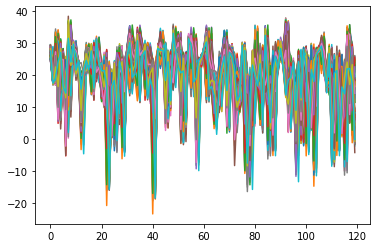

In [10]:
plt.plot(ts.reshape(ts.shape[1], ts.shape[0]))
plt.show()

## Time Series Clustering

Based on the similarity between clusters, we will apply four types of time series clustering:
- **Clustering whole dataframe**: Given a set of individual time series data, group similar time series into the same cluster;
- **Feature based clustering**: create features and use them to cluster time series;
- **Compression-based clustering**: compress time series and run clustering on the compressed versions.


### K-means

In [11]:
km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=0)
km.fit(ts)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=0)

The DTW metric is better when we want to clusterize time series. Euclidean distance is more sensible to distortion in the data.

Appending label to the dataset

In [12]:
set_labels(km)

Plot the cluster centers.

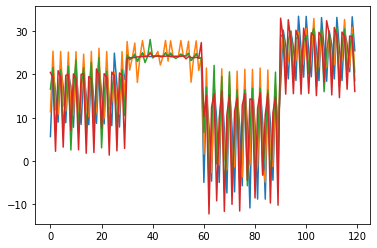

In [13]:
plt.plot(km.cluster_centers_.reshape(ts.shape[1], 4))
plt.show()

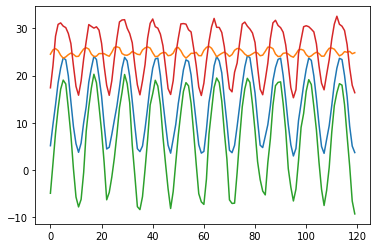

In [14]:
for i in range(4):
    plt.plot(np.mean(ts[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

In [15]:
km.inertia_

713.6828182860202

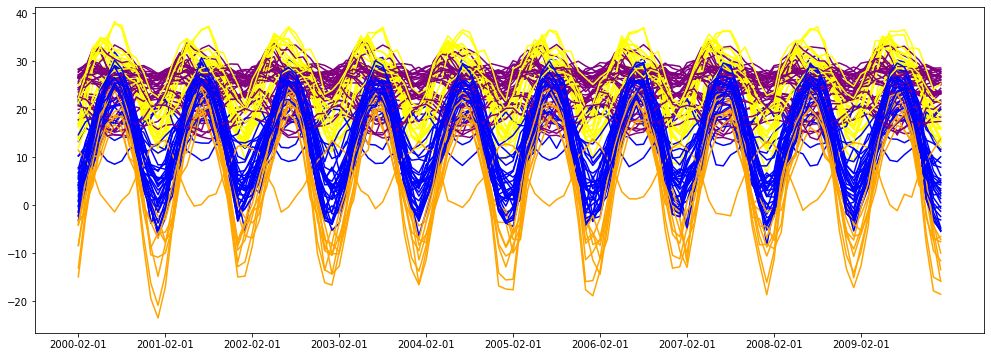

In [16]:
plot_time_series()

### Feature-based

For each city, extract some statistical features (e.g. average, standard deviation) and use them for the clustering.

In [17]:
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [18]:
Features = [list(calculate_features(x).values())[:-2] for x in ts]

Run k-means on the obtained features.

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(Features)

KMeans(n_clusters=4)

Rewrite label in the dataset according to the new clusters.

In [20]:
set_labels(kmeans)

Plotting cluster centroids.

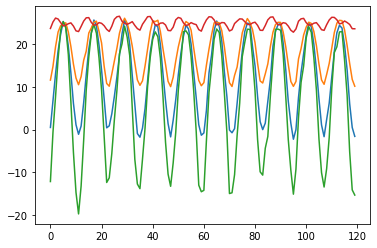

In [21]:
for i in range(4):
    plt.plot(np.mean(ts[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [22]:
kmeans.inertia_

37570.397120698035

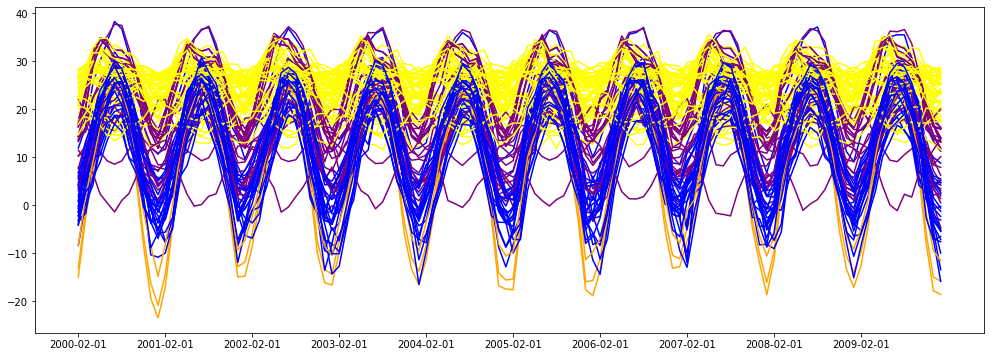

In [23]:
plot_time_series()

This is a worst clustering result with respect to the KMeans run on the original dataset. The inertia parameter is higher and as we observe from the last plot the data are not well distributed among the clusters.

### Compressed-based

The compressed space is not necessarily understandable.
PAA Represent the time series as as equence of box basis functions with each box of the same size. It reduces the data from n dimensions to M dimensions by dividing the time series into M equi-sized frames.

In [24]:
from tslearn.piecewise import PiecewiseAggregateApproximation
n_paa_segments = 80
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(ts)

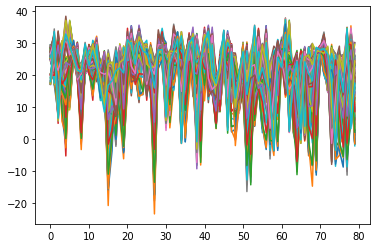

In [25]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [27]:
km_comp = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=0)
km_comp.fit(X_paa)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=0)

re assigning label attribute.

In [28]:
set_labels(km_comp)

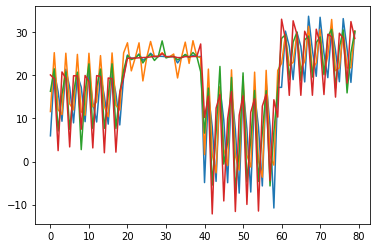

In [29]:
plt.plot(km_comp.cluster_centers_.reshape(X_paa.shape[1], 4))
plt.show()

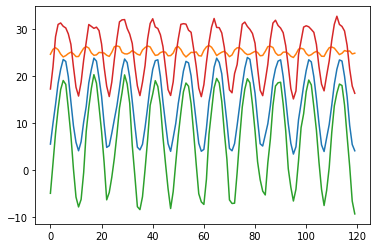

In [30]:
for i in range(4):
    plt.plot(np.mean(ts[np.where(km_comp.labels_ == i)[0]], axis=0))
plt.show()

In [31]:
km_comp.inertia_

487.66902223863116

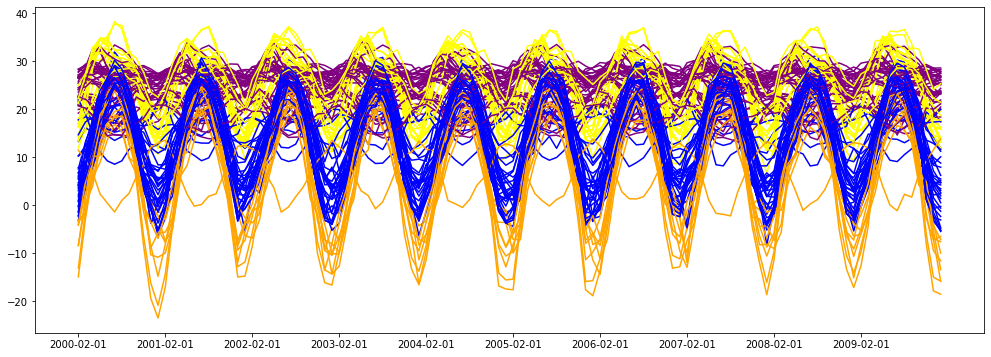

In [32]:
plot_time_series()

This last clustering method works very well. The inertia is the lower value we have observed during this analysis. This last clustering has been run on a compressed version of the data obtained by applying Piecewise Aggregate Approximation. 

## Map plot

In [33]:
latitude_list = []
longitude_list = []
latitude_dict = {}
longitude_dict = {}

for city in cities:
    latitude_dict[city] = df[df['City'] == city]['Latitude'].tolist()[0]
    longitude_dict[city] = df[df['City'] == city]['Longitude'].tolist()[0]
    
    lat = latitude_dict[city]
    lon = longitude_dict[city]
    
    last_char = lat[len(lat) -1]
    lat = float(lat[0:(len(lat)-1)])
    if last_char == 'S':
        lat = -lat
        latitude_dict[city] = lat
    else:
        latitude_dict[city] = lat
        
    last_char = lon[len(lon) -1]
    lon = float(lon[0:(len(lon)-1)])
    if last_char == 'W':
        lon = -lon
        longitude_dict[city] = lon
    else:
        longitude_dict[city] = lon
        
    latitude_list.append(latitude_dict[city])
    longitude_list.append(longitude_dict[city])
    

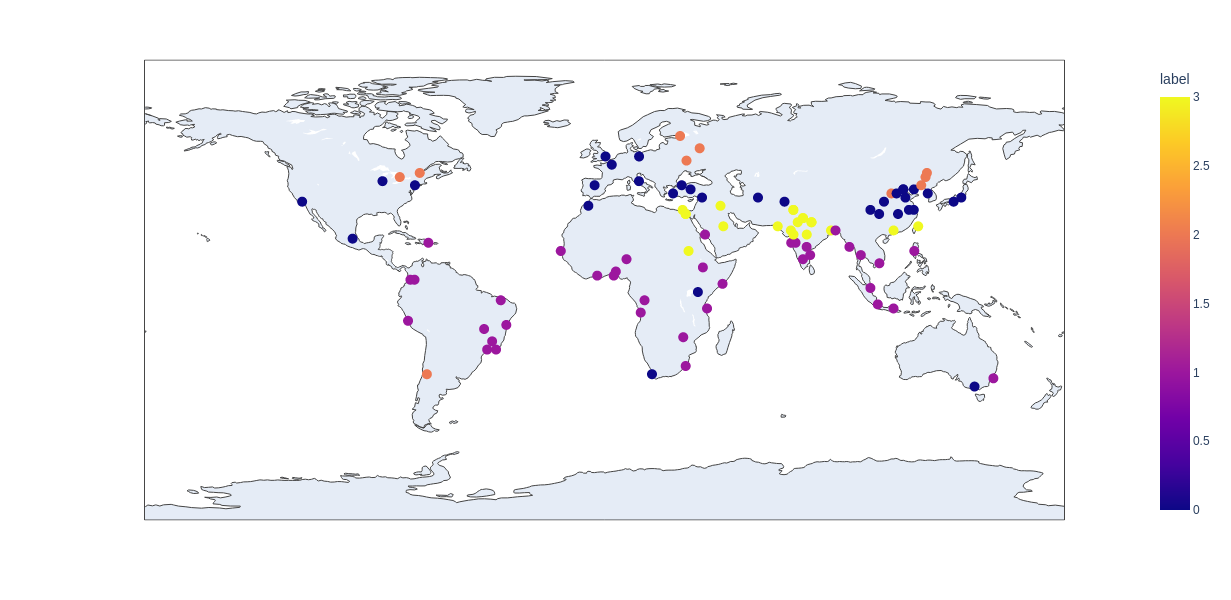

In [34]:
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go

mapbox_access_token = "pk.eyJ1IjoibW9uaWNhdDE4OTUiLCJhIjoiY2t4eXJxdGhxMmhydzJ3bzB3dDJ0Z3V0NSJ9.hAO2WDRTl2vjcMX9-wRDpA"
df2 = df[["City", "label"]].drop_duplicates()

px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_geo(df2,
                    lat=latitude_list,
                    lon=longitude_list,
                    hover_name=cities,
                    color="label", 
                    width=1200, height=600)
fig.update_traces(marker=dict(size=10))
fig.show()

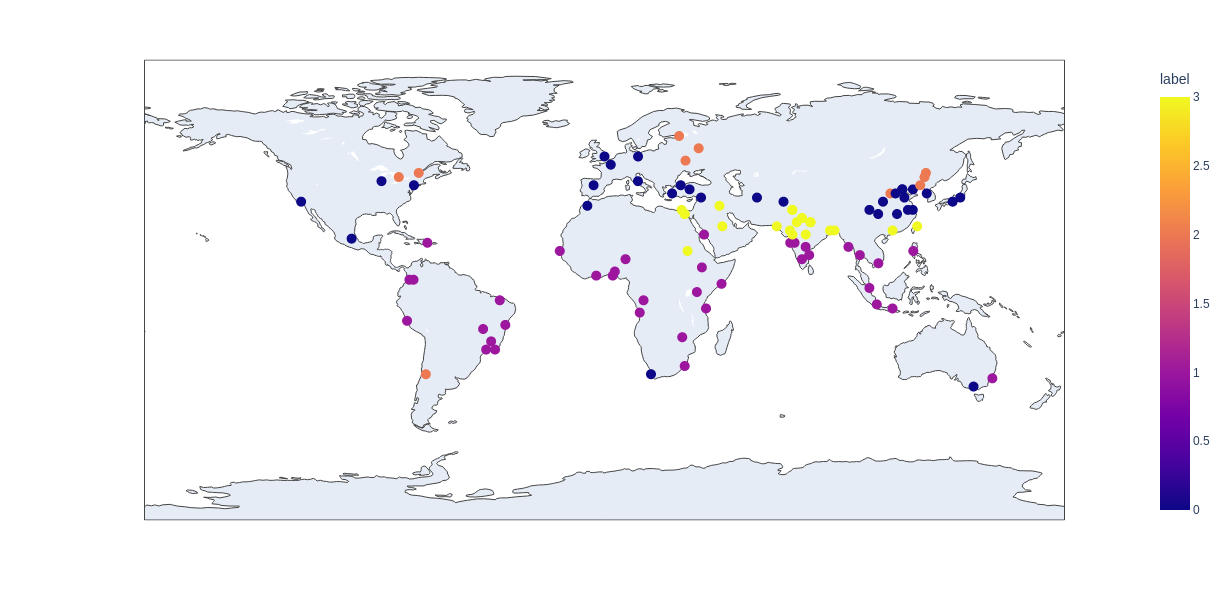

In [39]:
set_labels(km)

df2 = df[["City", "label"]].drop_duplicates()

px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_geo(df2,
                    lat=latitude_list,
                    lon=longitude_list,
                    hover_name=cities,
                    color="label", 
                    width=1200, height=600)
fig.update_traces(marker=dict(size=10))
fig.show()

Checking why santiago is orange: let's plot the mean of each clusters with also the average temperatue of santiago.

0.0    120
Name: label, dtype: int64
1.0    120
Name: label, dtype: int64
2.0    120
Name: label, dtype: int64


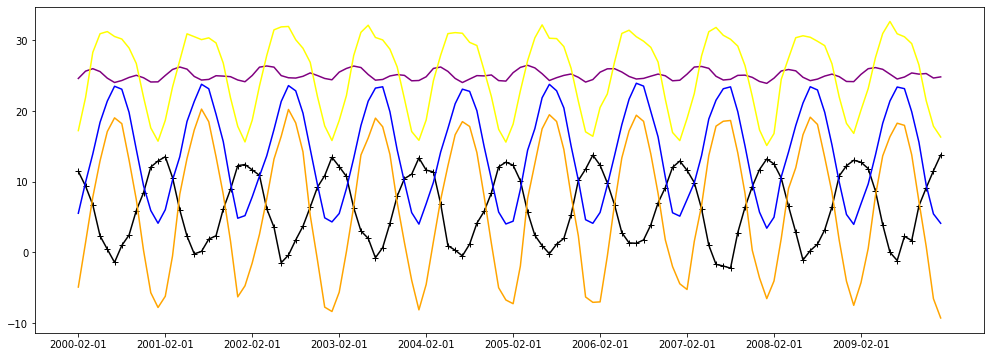

In [40]:
print (df[df['City'] == 'Cape Town']['label'].value_counts())
print (df[df['City'] == 'Durban']['label'].value_counts())
print (df[df['City'] == 'Santiago']['label'].value_counts())

colors=['blue', 'purple', 'orange', 'yellow']

dates = df['time'].unique()

fig, axs = plt.subplots(figsize=(17,6))

plt.plot(dates, df[df['City'] == 'Santiago']['AverageTemperature'], marker="+", color=(0,0,0))
for i in range(4):
    plt.plot(np.mean(ts[np.where(km_comp.labels_ == i)[0]], axis=0), color=colors[i])
    
axs.set_xticks(axs.get_xticks()[::12])
plt.show()